In [ ]:
# імпортуємо необхідні бібліотеки
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D 
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
# from alexnet import AlexNet

In [ ]:
# завантажуємо датасет fashion-mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
#Alexnet model for feature extraction

model = Sequential()
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(28, (5, 5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(28, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('softmax'))

In [ ]:
#compile model
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 52s 26ms/step - loss: 0.7871 - accuracy: 0.7675
Epoch 2/5
1875/1875 [==============================] - 50s 26ms/step - loss: 0.5408 - accuracy: 0.8332
Epoch 3/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.4810 - accuracy: 0.8493
Epoch 4/5
1875/1875 [==============================] - 51s 27ms/step - loss: 0.4442 - accuracy: 0.8581
Epoch 5/5
1875/1875 [==============================] - 66s 35ms/step - loss: 0.4149 - accuracy: 0.8676


In [ ]:
from keras.layers import concatenate
import tensorflow as tf

img_a_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = tf.keras.layers.Dense(16, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 16)           336         ['merge_features[1][0

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

In [ ]:
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

1/1 [==============================] - 0s 95ms/step


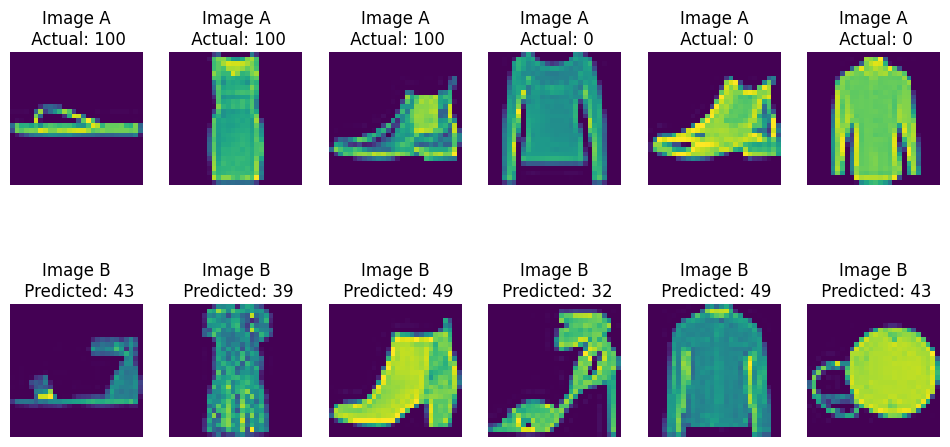

In [ ]:
import matplotlib.pyplot as plt
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 4,
    verbose = True)

1/1 [==============================] - 0s 36ms/step
Epoch 1/4
500/500 [==============================] - 108s 214ms/step - loss: 0.5439 - mae: 0.3960 - val_loss: 0.4002 - val_mae: 0.3003
Epoch 2/4
500/500 [==============================] - 117s 234ms/step - loss: 0.3003 - mae: 0.2205 - val_loss: 0.2377 - val_mae: 0.1570
Epoch 3/4
500/500 [==============================] - 123s 246ms/step - loss: 0.2306 - mae: 0.1503 - val_loss: 0.2027 - val_mae: 0.1281
Epoch 4/4
500/500 [==============================] - 130s 261ms/step - loss: 0.1918 - mae: 0.1194 - val_loss: 0.1987 - val_mae: 0.1120


1/1 [==============================] - 0s 36ms/step


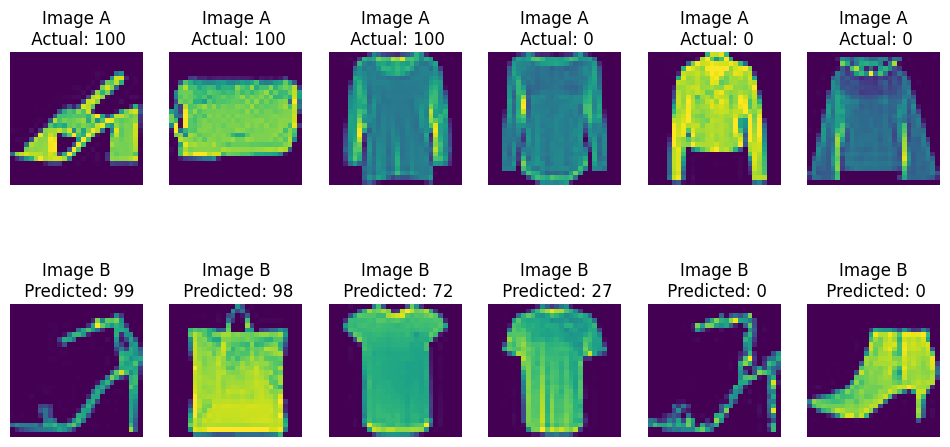

In [ ]:
_ = show_model_output()

In [ ]:
%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 2s 20ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 0.753s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.445351
[t-SNE] KL divergence aft

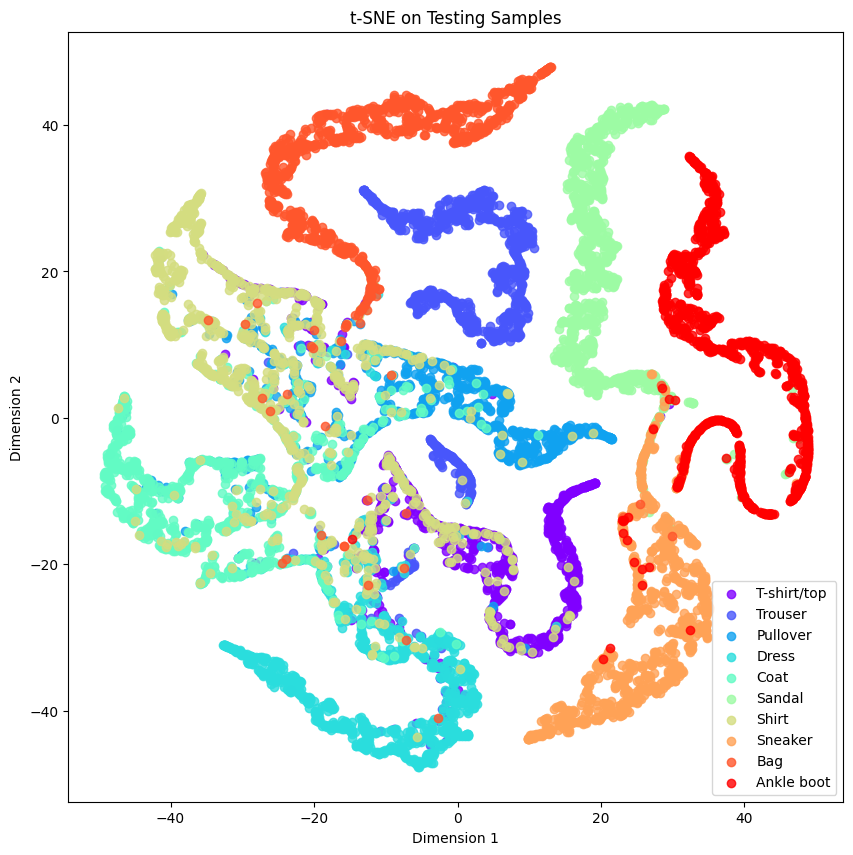

In [ ]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)